Now we check hypothesis of log dependency of price impact and try to estimate regression parameters. Remind that we need coefficient of regression
$$
\overline{\Delta p} = K \log V
$$

Alternative hypothesis is power law:
$$
\overline{\Delta p } = K V^{\beta}
$$
or more precisely
$$
\overline{\Delta p } = K (V-1)^{\beta}
$$
with $\beta = 1$ for linear case

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import gls
import os, sys
import json

In [3]:
files = [fname for fname in os.listdir('./data')]
files

['BRM2.feather',
 'CRM2.feather',
 'EDM2.feather',
 'EuM2.feather',
 'GDM2.feather',
 'GZM2.feather',
 'NGM2.feather',
 'RIM2.feather',
 'RMM2.feather',
 'SiM2.feather',
 'SRM2.feather',
 'VBM2.feather']

In [4]:
df = pd.read_feather('./data/CRM2.feather')
df.head()

,Time,MOMENT,DIRECTION,PRICE_min,PRICE_max,VOLUME_sum,DELTA_OI_sum,Date,TimeOnly,DOW,H,Impact,BID,ASK,BID_SIZE,ASK_SIZE,MID,Spread
0,2022-05-04 10:01:30.870,20220504100130870,S,10.60,10.84,50,-62.0,2022-05-04,10:01:30.870000,3,10,0.24,10.60,11.70,23.0,1.0,11.150000,1.10
1,2022-05-04 10:01:31.140,20220504100131140,B,10.95,11.71,5,0.0,2022-05-04,10:01:31.140000,3,10,0.76,10.60,11.71,23.0,16.0,11.155001,1.11
2,2022-05-04 10:01:31.247,20220504100131247,S,11.25,11.25,6,-12.0,2022-05-04,10:01:31.247000,3,10,0.00,11.21,11.71,1.0,16.0,11.460000,0.50
3,2022-05-04 10:01:31.250,20220504100131250,S,10.39,11.21,40,0.0,2022-05-04,10:01:31.250000,3,10,0.82,10.39,11.71,4.0,16.0,11.050000,1.32
4,2022-05-04 10:01:31.260,20220504100131260,S,10.39,10.39,4,0.0,2022-05-04,10:01:31.260000,3,10,0.00,10.38,11.71,1320.0,16.0,11.045000,1.33


In [5]:
# Import pice steps
# with open('pricesteps.json', 'r') as f:
#     pricesteps = json.load(f)

pricesteps = {  'RI': 10,
                'RM': 0.5,
                'SR': 1,
                'GZ': 1,
                'VB': 1,
                'Si': 1,
                'Eu': 1,
                'ED': 0.0001,
                'CR': 0.01,
                'BR': 0.01,              
                'GD': 0.1,
                'NG': 0.001}

In [6]:
with open('pricesteps.json', 'w') as f:
    json.dump(pricesteps, f)

In [7]:
def prepare4reg(ticker, pricestep=1, binwidth=1):
    df = pd.read_feather(f'./data/{ticker}.feather')
    
    max_impact = np.percentile(df['Impact'][df['Impact'] > 0], 99.9)
    
    if binwidth == 1:        
        df_grouped = df[['VOLUME_sum', 'Impact']] \
            [(df['Impact'] > 0) & (df['Impact'] < max_impact)] \
            .groupby(by=['VOLUME_sum'], as_index=True, sort=True) \
            .mean()
    else:
        bins = np.arange(df['VOLUME_sum'].min(), df['VOLUME_sum'].max()+1, binwidth)
        df['VolBin'] = pd.cut(df['VOLUME_sum'], bins=bins)    
        df_grouped = df[['VolBin', 'Impact']] \
            [(df['Impact'] > 0) & (df['Impact'] < max_impact)] \
            .groupby(by=['VolBin'], as_index=True, sort=True) \
            .mean()
        df_grouped.index = df_grouped.index.map(lambda ab: (ab.left + ab.right)/2)
    
    return df_grouped.index.to_numpy(), \
           df_grouped['Impact'].values / pricestep

### Regression

In [8]:
def add2results(model_id, res, df):
    df.loc[model_id, 'R2'] = res.rsquared_adj
    df.loc[model_id, 'F-stat p-value'] = res.f_pvalue
    
    try:
        df.loc[model_id, 'K'] = res.params[1]
        df.loc[model_id, 'K p-value'] = res.pvalues[1]
        df.loc[model_id, 'Intercept'] = res.params[0]
        df.loc[model_id, 'Intercept p-value'] = res.pvalues[0]
    except IndexError:
        df.loc[model_id, 'K'] = res.params[0]
        df.loc[model_id, 'K p-value'] = res.pvalues[0]
        df.loc[model_id, 'Intercept'] = 0
        df.loc[model_id, 'Intercept p-value'] = 0


In [9]:
def fit_model(ticker, pricestep, 
              reg_range=[None, None], plot_range=None, 
              binwidth=1, model='lin', verbose=True):
    
    X, Y = prepare4reg(ticker, pricestep, binwidth)
    if plot_range is None:
        plot_range = [X.min(), X.max()]
    if reg_range is None:
        reg_range = plot_range
    
    x = X[(X >= reg_range[0]) & (X <= reg_range[1])]
    y = Y[(X >= reg_range[0]) & (X <= reg_range[1])]
    dxy = pd.DataFrame({'x': x, 'y': y})
    
    if model == 'lin':
        model = gls('y ~ x', dxy)
        res = model.fit()
        linreg = lambda x: res.params[0] + res.params[1] * x
    
    elif model == 'lin0':
        dxy.x -= 1
        model = gls('y ~ x -1', dxy)
        res = model.fit()
        linreg = lambda x: res.params[0] * x

    elif model == 'log':
        model = gls('y ~ np.log(x)', dxy)
        res = model.fit()
        linreg = lambda x: res.params[0] + res.params[1] * np.log(x)

    elif model == 'pow':
        dxy.x, dxy.y = np.log(x-1), np.log(y)
        model = gls('y ~ x', dxy)
        res = model.fit()
        linreg = lambda x: np.exp(res.params[0]) * x**res.params[1] 
    
    else:
        raise ValueError('Unknown model')
    
    if verbose:
        plt.title(f'{ticker}, {model} model')
        sns.scatterplot(X[(X >= plot_range[0]) & (X <= plot_range[1])], 
                        Y[(X >= plot_range[0]) & (X <= plot_range[1])])
        
        xr = np.linspace(reg_range[0], reg_range[1], 100)
        sns.lineplot(xr, linreg(xr), color='r')
         
    return res, x, y

In [10]:
df_results = pd.DataFrame(columns=['R2', 'F-stat p-value',
                                   'K', 'K p-value', 
                                   'Intercept', 'Intercept p-value'])

## RIM2

R2                   0.993747
F-stat p-value            0.0
K                    1.521797
K p-value                 0.0
Intercept            8.922255
Intercept p-value         0.0
Name: RIM2 : lin : [1, 20], dtype: object


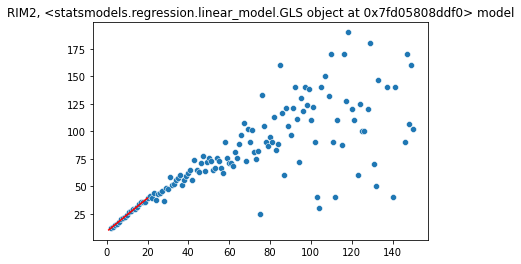

In [66]:
ticker = 'RIM2'
reg_range = [1, 20]
plot_range = [1, 150]
model = 'lin'

model_id = ticker + ' : ' + model + ' : ' + str(reg_range) 

res, x, y = fit_model(ticker, 1, reg_range, plot_range, binwidth=1, model=model)
add2results(model_id, res, df_results)
print(df_results.loc[model_id])

R2                    0.554902
F-stat p-value             0.0
K                    43.901909
K p-value                  0.0
Intercept           -99.066644
Intercept p-value     0.001243
Name: RIM2 : log : [30, 150], dtype: object


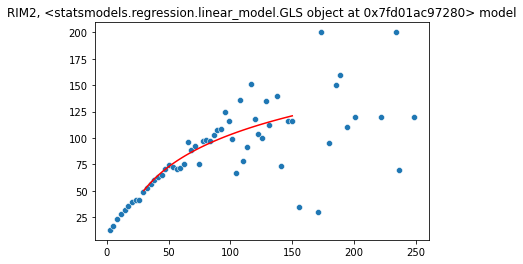

In [71]:
ticker = 'RIM2'
reg_range = [30, 150]
plot_range = [1, 300]
model = 'log'

model_id = ticker + ' : ' + model + ' : ' + str(reg_range) 

res, x, y = fit_model(ticker, 1, reg_range, plot_range, binwidth=3, model=model)
add2results(model_id, res, df_results)
print(df_results.loc[model_id])

R2                   0.454716
F-stat p-value       0.000002
K                    0.536137
K p-value            0.000002
Intercept           -1.845631
Intercept p-value    0.000076
Name: RMM2 : pow : [30, 150], dtype: object


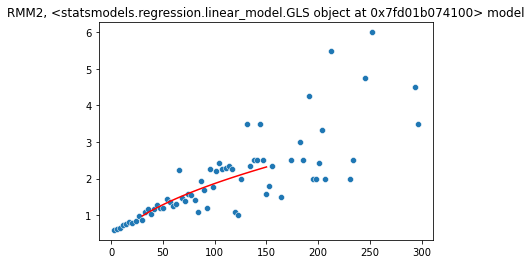

In [74]:
reg_range = [30, 150]
model = 'pow'

model_id = ticker + ' : ' + model + ' : ' + str(reg_range) 

res, x, y = fit_model(ticker, 1, reg_range, plot_range, binwidth=3, model=model)
add2results(model_id, res, df_results)
print(df_results.loc[model_id])

## RMM2

R2                   0.837113
F-stat p-value            0.0
K                    0.012141
K p-value                 0.0
Intercept            0.570515
Intercept p-value         0.0
Name: RMM2 : lin : [1, 25], dtype: object


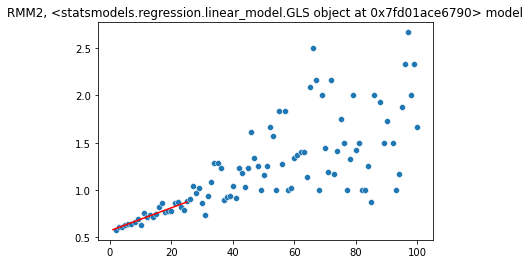

In [67]:
ticker = 'RMM2'
reg_range = [1, 25]
plot_range = [1, 100]
model = 'lin'

model_id = ticker + ' : ' + model + ' : ' + str(reg_range) 

res, x, y = fit_model(ticker, 1, reg_range, plot_range, binwidth=1, model=model)
add2results(model_id, res, df_results)
print(df_results.loc[model_id])

R2                    0.37702
F-stat p-value       0.000004
K                    1.020466
K p-value            0.000004
Intercept            -2.76609
Intercept p-value     0.00372
Name: RMM2 : log : [40, 200], dtype: object


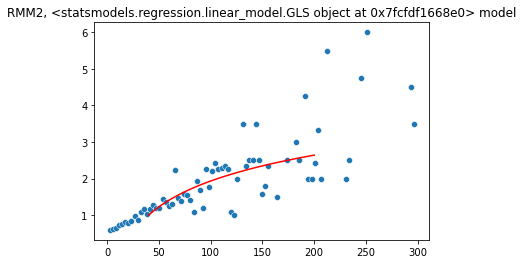

In [73]:
ticker = 'RMM2'
plot_range = [1, 300]
reg_range = [40, 200]
model = 'log'

model_id = ticker + ' : ' + model + ' : ' + str(reg_range) 

res, x, y = fit_model(ticker, 1, reg_range, plot_range, binwidth=3, model=model)
add2results(model_id, res, df_results)
print(df_results.loc[model_id])

## SRM2

R2                   0.986235
F-stat p-value            0.0
K                    0.061374
K p-value                 0.0
Intercept            1.266973
Intercept p-value         0.0
Name: SRM2 : lin : [1, 30], dtype: object


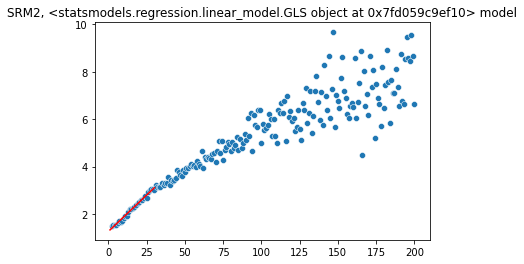

In [23]:
ticker = 'SRM2'
reg_range = [1, 30]
plot_range = [1, 200]
model = 'lin'

model_id = ticker + ' : ' + model + ' : ' + str(reg_range) 

res, x, y = fit_model(ticker, 1, reg_range, plot_range, binwidth=1, model=model)
add2results(model_id, res, df_results)
print(df_results.loc[model_id])

R2                   0.852486
F-stat p-value            0.0
K                    2.298605
K p-value                 0.0
Intercept           -5.080272
Intercept p-value         0.0
Name: SRM2 : log : [30, 100], dtype: object


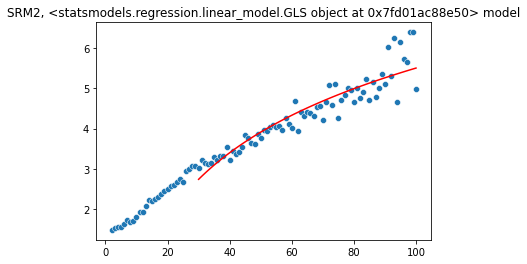

In [24]:
ticker = 'SRM2'
reg_range = [30, 100]
plot_range = [1, 100]
model = 'log'

model_id = ticker + ' : ' + model + ' : ' + str(reg_range) 

res, x, y = fit_model(ticker, 1, reg_range, plot_range, binwidth=1, model=model)
add2results(model_id, res, df_results)
print(df_results.loc[model_id])

R2                   0.882534
F-stat p-value            0.0
K                    0.038907
K p-value                 0.0
Intercept            1.859801
Intercept p-value         0.0
Name: SRM2 : lin : [30, 100], dtype: object


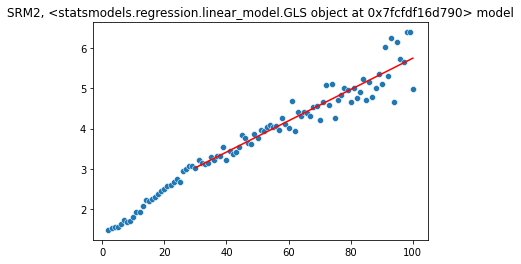

In [25]:
ticker = 'SRM2'
reg_range = [30, 100]
plot_range = [1, 100]
model = 'lin'

model_id = ticker + ' : ' + model + ' : ' + str(reg_range) 

res, x, y = fit_model(ticker, 1, reg_range, plot_range, binwidth=1, model=model)
add2results(model_id, res, df_results)
print(df_results.loc[model_id])

## GZM2

R2                   0.974992
F-stat p-value       0.000021
K                    0.370951
K p-value            0.000021
Intercept            2.111342
Intercept p-value    0.000193
Name: GZM2 : lin : [1, 15], dtype: object


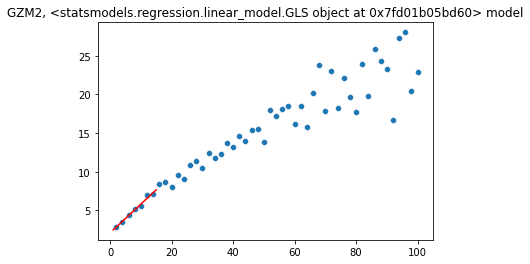

In [27]:
ticker = 'GZM2'
reg_range = [1, 15]
plot_range = [1, 100]
model = 'lin'

model_id = ticker + ' : ' + model + ' : ' + str(reg_range) 

res, x, y = fit_model(ticker, 1, reg_range, plot_range, binwidth=2, model=model)
add2results(model_id, res, df_results)
print(df_results.loc[model_id])

R2                    0.818642
F-stat p-value             0.0
K                     9.562488
K p-value                  0.0
Intercept           -20.748494
Intercept p-value          0.0
Name: GZM2 : log : [15, 100], dtype: object


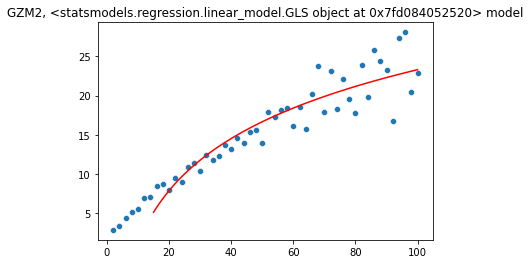

In [29]:
ticker = 'GZM2'
reg_range = [15, 100]
plot_range = [1, 100]
model = 'log'

model_id = ticker + ' : ' + model + ' : ' + str(reg_range) 

res, x, y = fit_model(ticker, 1, reg_range, plot_range, binwidth=2, model=model)
add2results(model_id, res, df_results)
print(df_results.loc[model_id])

R2                   0.825713
F-stat p-value            0.0
K                    0.195245
K p-value                 0.0
Intercept            5.678632
Intercept p-value         0.0
Name: GZM2 : lin : [15, 100], dtype: object


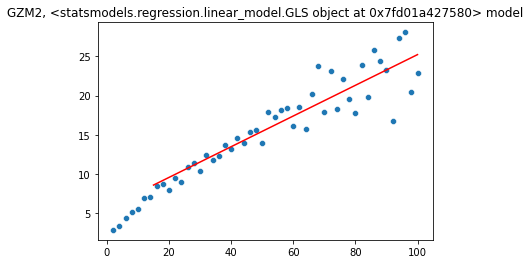

In [30]:
ticker = 'GZM2'
reg_range = [15, 100]
plot_range = [1, 100]
model = 'lin'

model_id = ticker + ' : ' + model + ' : ' + str(reg_range) 

res, x, y = fit_model(ticker, 1, reg_range, plot_range, binwidth=2, model=model)
add2results(model_id, res, df_results)
print(df_results.loc[model_id])

## SiM2

R2                   0.985881
F-stat p-value            0.0
K                    0.143637
K p-value                 0.0
Intercept            2.082624
Intercept p-value         0.0
Name: SiM2 : lin : [1, 40], dtype: object


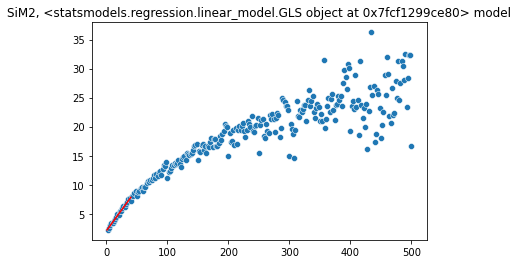

In [32]:
ticker = 'SiM2'
reg_range = [1, 40]
plot_range = [1, 500]
model = 'lin'

model_id = ticker + ' : ' + model + ' : ' + str(reg_range) 

res, x, y = fit_model(ticker, 1, reg_range, plot_range, binwidth=2, model=model)
add2results(model_id, res, df_results)
print(df_results.loc[model_id])

R2                    0.833323
F-stat p-value             0.0
K                     8.156504
K p-value                  0.0
Intercept           -24.854961
Intercept p-value          0.0
Name: SiM2 : log : [60, 500], dtype: object


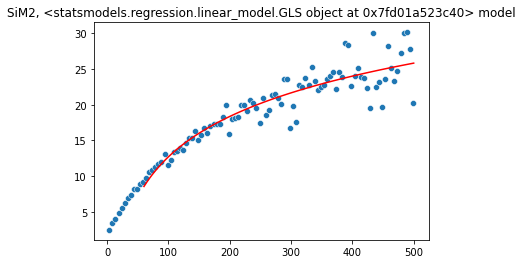

In [33]:
ticker = 'SiM2'
reg_range = [60, 500]
plot_range = [1, 500]
model = 'log'

model_id = ticker + ' : ' + model + ' : ' + str(reg_range) 

res, x, y = fit_model(ticker, 1, reg_range, plot_range, binwidth=5, model=model)
add2results(model_id, res, df_results)
print(df_results.loc[model_id])

R2                   0.964325
F-stat p-value            0.0
K                    0.485189
K p-value                 0.0
Intercept            0.290319
Intercept p-value         0.0
Name: SiM2 : pow : [1, 500], dtype: object


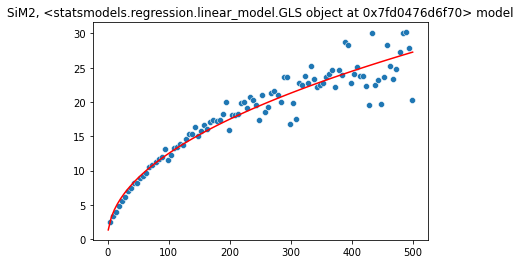

In [34]:
ticker = 'SiM2'
reg_range = [1, 500]
plot_range = [1, 500]
model = 'pow'

model_id = ticker + ' : ' + model + ' : ' + str(reg_range) 

res, x, y = fit_model(ticker, 1, reg_range, plot_range, binwidth=5, model=model)
add2results(model_id, res, df_results)
print(df_results.loc[model_id])

## EuM2

R2                   0.979289
F-stat p-value            0.0
K                    0.695656
K p-value                 0.0
Intercept             2.44312
Intercept p-value    0.000502
Name: EuM2 : lin : [1, 18], dtype: object


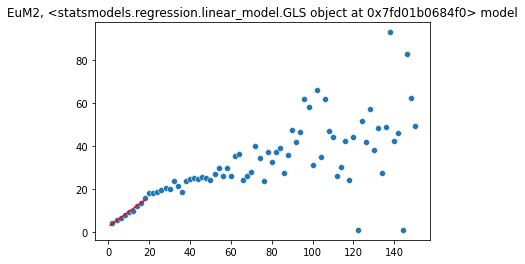

In [35]:
ticker = 'EuM2'
reg_range = [1, 18]
plot_range = [1, 150]
model = 'lin'

model_id = ticker + ' : ' + model + ' : ' + str(reg_range) 

res, x, y = fit_model(ticker, 1, reg_range, plot_range, binwidth=2, model=model)
add2results(model_id, res, df_results)
print(df_results.loc[model_id])

R2                   0.336378
F-stat p-value            0.0
K                    0.250721
K p-value                 0.0
Intercept            14.17039
Intercept p-value    0.000641
Name: EuM2 : lin : [18, 150], dtype: object


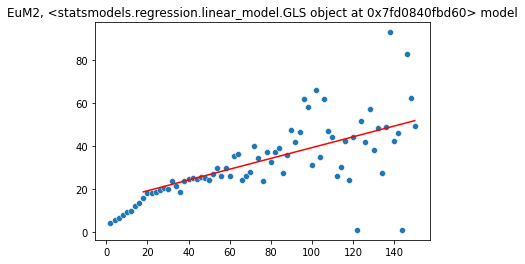

In [36]:
ticker = 'EuM2'
reg_range = [18, 150]
plot_range = [1, 150]
model = 'lin'

model_id = ticker + ' : ' + model + ' : ' + str(reg_range) 

res, x, y = fit_model(ticker, 1, reg_range, plot_range, binwidth=2, model=model)
add2results(model_id, res, df_results)
print(df_results.loc[model_id])

R2                    0.616422
F-stat p-value             0.0
K                    14.166459
K p-value                  0.0
Intercept             -25.9242
Intercept p-value     0.000049
Name: EuM2 : log : [5, 120], dtype: object


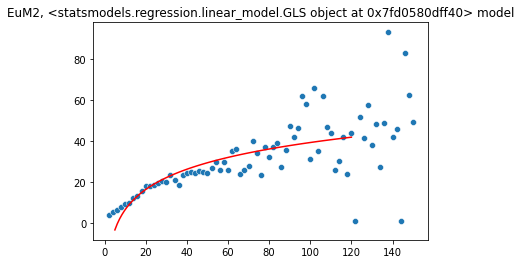

In [39]:
ticker = 'EuM2'
reg_range = [5, 120]
plot_range = [1, 150]
model = 'log'

model_id = ticker + ' : ' + model + ' : ' + str(reg_range) 

res, x, y = fit_model(ticker, 1, reg_range, plot_range, binwidth=2, model=model)
add2results(model_id, res, df_results)
print(df_results.loc[model_id])

## EDM2

R2                   0.988361
F-stat p-value            0.0
K                    0.000004
K p-value                 0.0
Intercept            0.000125
Intercept p-value         0.0
Name: EDM2 : lin : [1, 20], dtype: object


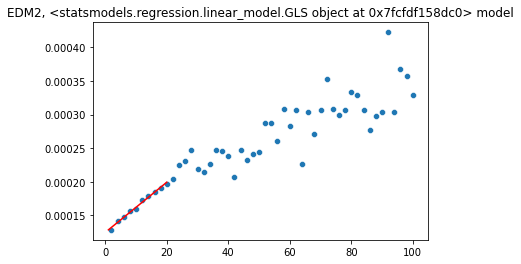

In [68]:
ticker = 'EDM2'
reg_range = [1, 20]
plot_range = [1, 100]
model = 'lin'

model_id = ticker + ' : ' + model + ' : ' + str(reg_range) 

res, x, y = fit_model(ticker, 1, reg_range, plot_range, binwidth=2, model=model)
add2results(model_id, res, df_results)
print(df_results.loc[model_id])

R2                   0.680273
F-stat p-value            0.0
K                    0.000092
K p-value                 0.0
Intercept            -0.00009
Intercept p-value    0.029714
Name: EDM2 : log : [20, 100], dtype: object


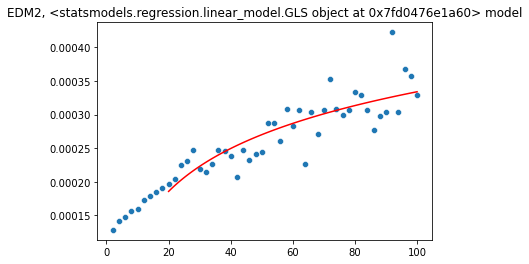

In [69]:
ticker = 'EDM2'
reg_range = [20, 100]
plot_range = [1, 100]
model = 'log'

model_id = ticker + ' : ' + model + ' : ' + str(reg_range) 

res, x, y = fit_model(ticker, 1, reg_range, plot_range, binwidth=2, model=model)
add2results(model_id, res, df_results)
print(df_results.loc[model_id])

## CRM2

R2                   0.063865
F-stat p-value       0.168687
K                    0.000411
K p-value            0.168687
Intercept            0.028954
Intercept p-value    0.000167
Name: CRM2 : lin : [1, 35], dtype: object


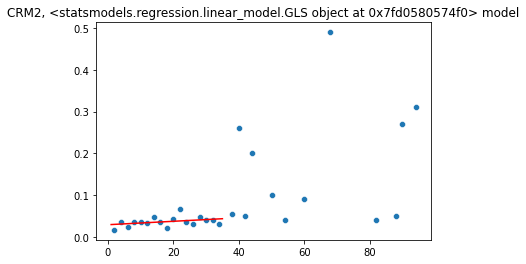

In [75]:
ticker = 'CRM2'
reg_range = [1, 35]
plot_range = [1, 100]
model = 'lin'

model_id = ticker + ' : ' + model + ' : ' + str(reg_range) 

res, x, y = fit_model(ticker, 1, reg_range, plot_range, binwidth=2, model=model)
add2results(model_id, res, df_results)
print(df_results.loc[model_id])

## BRM2

R2                   0.827019
F-stat p-value            0.0
K                    0.000491
K p-value                 0.0
Intercept            0.014023
Intercept p-value    0.000045
Name: BRM2 : lin : [1, 200], dtype: object


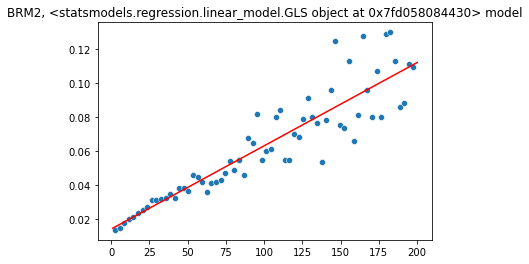

In [76]:
ticker = 'BRM2'
reg_range = [1, 200]
plot_range = [1, 200]
model = 'lin'

model_id = ticker + ' : ' + model + ' : ' + str(reg_range) 

res, x, y = fit_model(ticker, 1, reg_range, plot_range, binwidth=3, model=model)
add2results(model_id, res, df_results)
print(df_results.loc[model_id])

R2                   0.656215
F-stat p-value            0.0
K                    0.049246
K p-value                 0.0
Intercept           -0.159736
Intercept p-value         0.0
Name: BRM2 : log : [40, 180], dtype: object


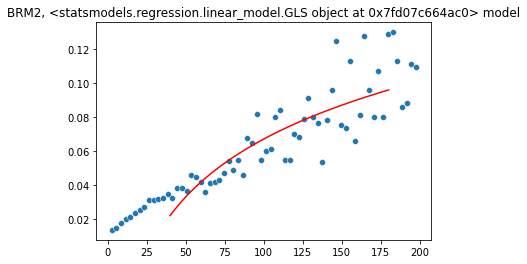

In [77]:
ticker = 'BRM2'
reg_range = [40, 180]
plot_range = [1, 200]
model = 'log'

model_id = ticker + ' : ' + model + ' : ' + str(reg_range) 

res, x, y = fit_model(ticker, 1, reg_range, plot_range, binwidth=3, model=model)
add2results(model_id, res, df_results)
print(df_results.loc[model_id])

R2                    0.71854
F-stat p-value            0.0
K                    0.000503
K p-value                 0.0
Intercept            0.012739
Intercept p-value    0.016446
Name: BRM2 : lin : [30, 180], dtype: object


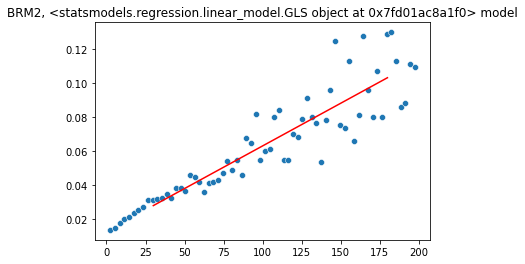

In [78]:
ticker = 'BRM2'
reg_range = [30, 180]
plot_range = [1, 200]
model = 'lin'

model_id = ticker + ' : ' + model + ' : ' + str(reg_range) 

res, x, y = fit_model(ticker, 1, reg_range, plot_range, binwidth=3, model=model)
add2results(model_id, res, df_results)
print(df_results.loc[model_id])

## GDM2

R2                   0.983729
F-stat p-value            0.0
K                    0.010016
K p-value                 0.0
Intercept            0.115535
Intercept p-value         0.0
Name: GDM2 : lin : [1, 30], dtype: object


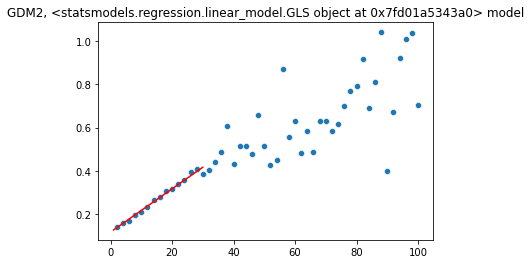

In [79]:
ticker = 'GDM2'
reg_range = [1, 30]
plot_range = [1, 100]
model = 'lin'

model_id = ticker + ' : ' + model + ' : ' + str(reg_range) 

res, x, y = fit_model(ticker, 1, reg_range, plot_range, binwidth=2, model=model)
add2results(model_id, res, df_results)
print(df_results.loc[model_id])

R2                   0.650517
F-stat p-value            0.0
K                    0.256155
K p-value                 0.0
Intercept           -0.451195
Intercept p-value    0.001087
Name: GDM2 : log : [15, 80], dtype: object


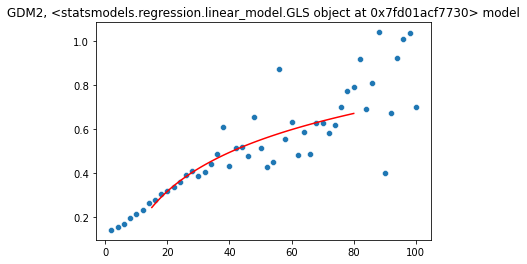

In [87]:
ticker = 'GDM2'
reg_range = [15, 80]
plot_range = [1, 100]
model = 'log'

model_id = ticker + ' : ' + model + ' : ' + str(reg_range) 

res, x, y = fit_model(ticker, 1, reg_range, plot_range, binwidth=2, model=model)
add2results(model_id, res, df_results)
print(df_results.loc[model_id])

## NGM2

R2                    0.93436
F-stat p-value            0.0
K                    0.000383
K p-value                 0.0
Intercept            0.001069
Intercept p-value    0.001613
Name: NGM2 : lin : [1, 15], dtype: object


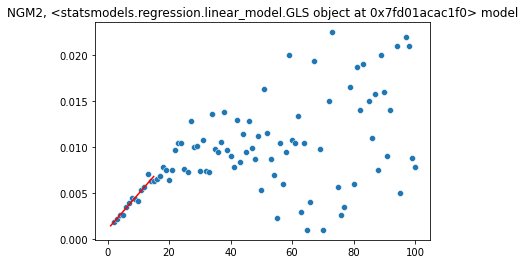

In [81]:
ticker = 'NGM2'
reg_range = [1, 15]
plot_range = [1, 100]
model = 'lin'

model_id = ticker + ' : ' + model + ' : ' + str(reg_range) 

res, x, y = fit_model(ticker, 1, reg_range, plot_range, binwidth=1, model=model)
add2results(model_id, res, df_results)
print(df_results.loc[model_id])

R2                   0.146553
F-stat p-value       0.006537
K                    0.003349
K p-value            0.006537
Intercept           -0.002425
Intercept p-value    0.604897
Name: NGM2 : log : [15, 100], dtype: object


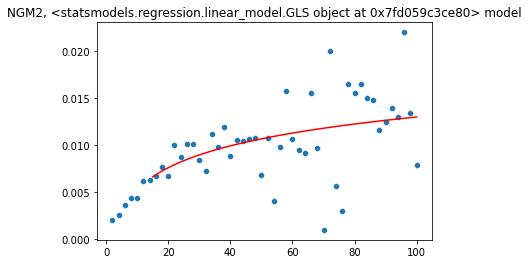

In [82]:
ticker = 'NGM2'
reg_range = [15, 100]
plot_range = [1, 100]
model = 'log'

model_id = ticker + ' : ' + model + ' : ' + str(reg_range) 

res, x, y = fit_model(ticker, 1, reg_range, plot_range, binwidth=2, model=model)
add2results(model_id, res, df_results)
print(df_results.loc[model_id])

R2                   0.296916
F-stat p-value       0.000037
K                    0.003393
K p-value            0.000037
Intercept           -0.002608
Intercept p-value    0.365371
Name: NGM2 : log : [5, 100], dtype: object


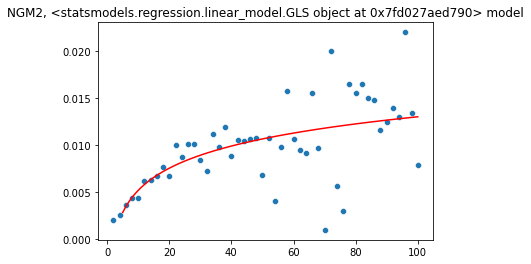

In [83]:
ticker = 'NGM2'
reg_range = [5, 100]
plot_range = [1, 100]
model = 'log'

model_id = ticker + ' : ' + model + ' : ' + str(reg_range) 

res, x, y = fit_model(ticker, 1, reg_range, plot_range, binwidth=2, model=model)
add2results(model_id, res, df_results)
print(df_results.loc[model_id])